In [18]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Paper replication I : Simulation

Simulation of a spread to include in the paper: "We simulate a synthetic spread as a noisy, mean-reverting stochastic process around a fixed equilibrium level, so that threshold-based trading strategies can be illustrated independently of real data."

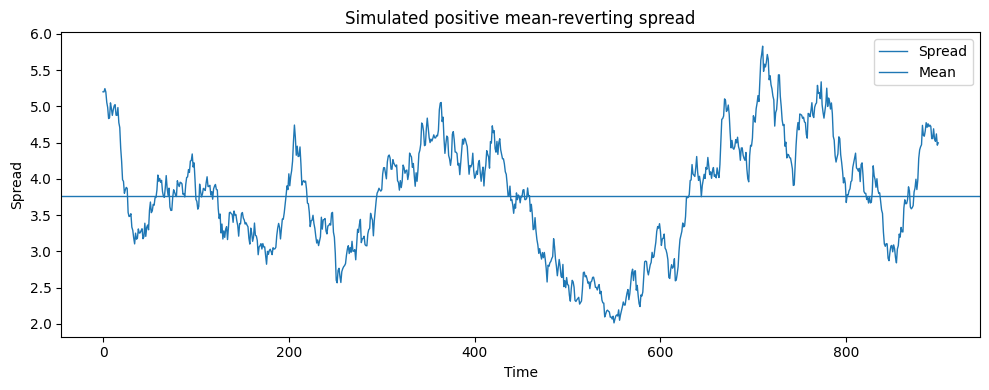

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from simul.utils.simulation import simulate_cir_spread

# --- generate fake spread ---
S = simulate_cir_spread(n=900, dt=1/252, s0=5.2, kappa=2.5, theta=5.0, sigma=1.1, seed=7)

mu = np.mean(S)

# --- plot like the paper: mean + constant bands ---

plt.figure(figsize=(10,4))
plt.plot(S, lw=1, label="Spread")
plt.axhline(mu, lw=1, label="Mean")
plt.title("Simulated positive mean-reverting spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.tight_layout()
plt.show()

## Benchmark trading strategies

In [20]:
from simul.trading.strategy import (
    strategy_A_signals, 
    strategy_B_signals, 
    find_trades,      # For Strategy A and C
    find_trades_B,    # For Strategy B
)

S = pd.Series(S, index=range(len(S)))

We will use the standard trading rule I to define the different tresholds (model (2) is linear mean reverting, homoscedastic, and Gaussian)

In [21]:
sigma = np.std(S)

k = 1 #nb of std 
U = mu + k*sigma
L = mu - k*sigma
C = mu
print(C)

3.7633821770586695


### Trading Strategy A 

In [22]:
signals_A = strategy_A_signals(S, U=U, L=L, C=C)
trades_A = find_trades(signals_A)

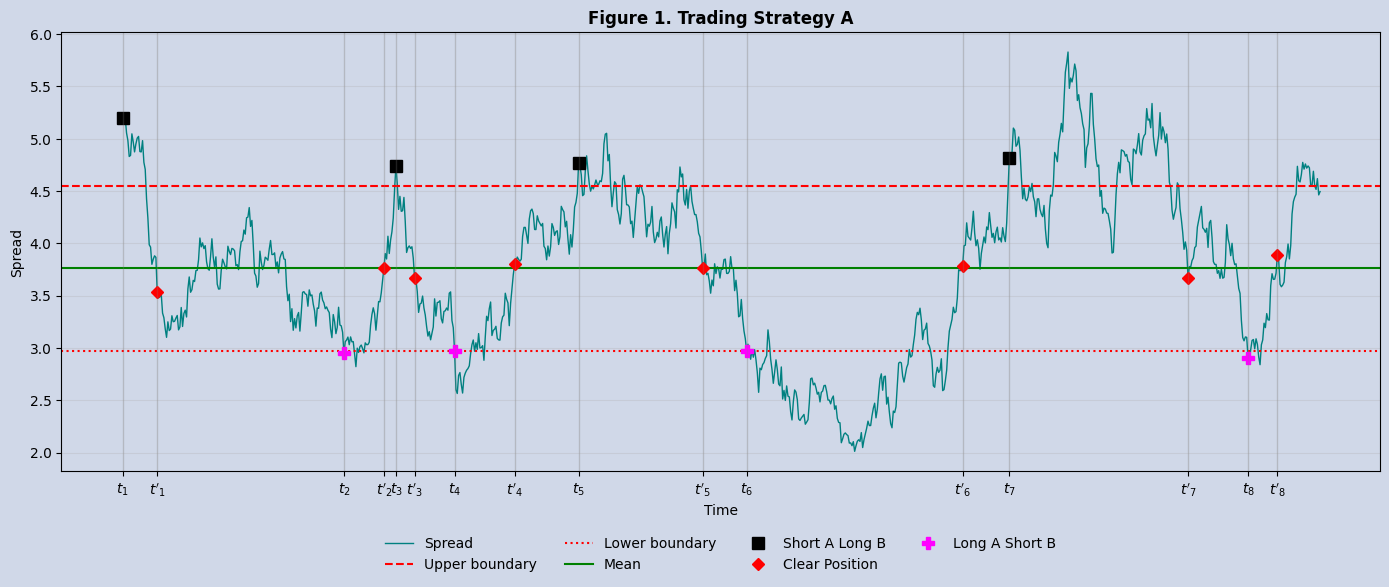

In [23]:
# --- compute signals/trades ---
signals_A = strategy_A_signals(S, U=U, L=L, C=C)
trades_A  = find_trades(signals_A)

# --- Plot Figure 1: Strategy A (legend like the paper) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')

# Thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Mark entry/exit points with paper symbols + robust legend labels
shown_short = False
shown_long  = False
shown_clear = False

# Build x-axis tick labels: t1, t1', t2, t2', ...
tick_pos, tick_lab = [], []

for i, trade in enumerate(trades_A[:8], start=1):
    entry = trade['entry']
    exit_ = trade['exit']

    entry_val = S.loc[entry]
    exit_val  = S.loc[exit_]

    # Entry markers
    if trade['type'] == 'short':
        # ■ Short A Long B
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        # ✚ Long A Short B (purple cross)
        ax.plot(entry, entry_val, marker='P', linestyle='None', color='magenta',
                markersize=8, label='Long A Short B' if not shown_long else '')
        shown_long = True

    # Exit marker: ◆ Clear Position
    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=6, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    # Optional: vertical lines at entry/exit (paper-like)
    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_, color='grey', alpha=0.25, linewidth=1)

    # Custom ticks
    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# Replace x-axis with t_i / t'_i
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lab)

# Titles/labels
ax.set_title('Figure 1. Trading Strategy A', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Legend (deduplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Trading Strategy B

In [24]:
# Apply Strategy B
signals_B = strategy_B_signals(S, U=U, L=L)

# Find trades using module function (B flips positions directly)
trades_B = find_trades_B(signals_B)

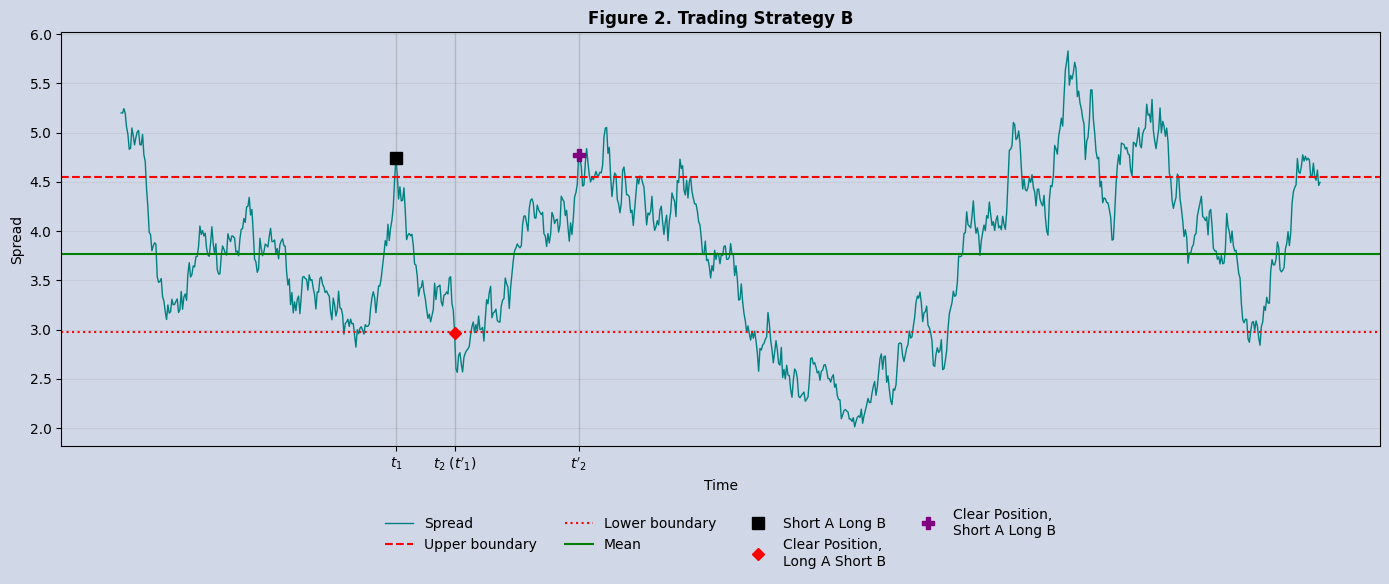

Chosen paper-like events:
t1   = 206   (up-cross U)   S=4.7410
t2=t1' = 250 (down-cross L) S=2.9684
t2'  = 343  (up-cross U)   S=4.7695


In [25]:
# --- Helper: find first crossing index after a start ---
def first_cross_up(series, level, start=1):
    # prev < level and curr >= level
    x = series.values
    idx = series.index
    for t in range(max(1, start), len(x)):
        if x[t-1] < level and x[t] >= level:
            return idx[t]
    return None

def first_cross_down(series, level, start=1):
    # prev > level and curr <= level
    x = series.values
    idx = series.index
    for t in range(max(1, start), len(x)):
        if x[t-1] > level and x[t] <= level:
            return idx[t]
    return None

# --- 1) Pick the 3 "paper-like" events from YOUR data ---
# t1: cross up through U
t1 = first_cross_up(S, U, start=1)
if t1 is None:
    raise ValueError("No up-crossing of U found (t1). Try different U or longer sample.")

# position in integer location
t1_loc = S.index.get_loc(t1)

# t2 (= t1'): next cross down through L after t1
t2 = first_cross_down(S, L, start=t1_loc+1)
if t2 is None:
    raise ValueError("No down-crossing of L found after t1 (t2=t1').")

t2_loc = S.index.get_loc(t2)

# t2': next cross up through U after t2
t2p = first_cross_up(S, U, start=t2_loc+1)
if t2p is None:
    raise ValueError("No next up-crossing of U found after t2 (t2').")

# Values at those times
S_t1  = S.loc[t1]
S_t2  = S.loc[t2]
S_t2p = S.loc[t2p]

# --- 2) Plot (replicate paper layout) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread + thresholds
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Vertical lines at key times (paper-like)
for xline in [t1, t2, t2p]:
    ax.axvline(xline, color='grey', alpha=0.25, linewidth=1)

# --- 3 markers exactly as you requested ---
# t1: black square (Short A Long B)
ax.plot(t1, S_t1, marker='s', linestyle='None', color='black', markersize=8,
        label='Short A Long B')

# t1' == t2: red diamond (Clear Position, Long A Short B)
ax.plot(t2, S_t2, marker='D', linestyle='None', color='red', markersize=6,
        label='Clear Position,\nLong A Short B')

# t2': purple cross (Clear Position, Short A Long B)
ax.plot(t2p, S_t2p, marker='P', linestyle='None', color='purple', markersize=8,
        label='Clear Position,\nShort A Long B')

# --- x-axis ticks like the paper ---
ax.set_xticks([t1, t2, t2p])
ax.set_xticklabels([r"$t_1$", r"$t_2\;(t'_1)$", r"$t'_2$"])

ax.set_title("Figure 2. Trading Strategy B", fontsize=12, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Spread")

# Legend: deduplicate (paper style)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Chosen paper-like events:")
print(f"t1   = {t1}   (up-cross U)   S={S_t1:.4f}")
print(f"t2=t1' = {t2} (down-cross L) S={S_t2:.4f}")
print(f"t2'  = {t2p}  (up-cross U)   S={S_t2p:.4f}")

## The New trading strategy

In [ ]:
from simul.trading.strategy import strategy_C_signals, strategy_C_signals_timevarying

On passe a la strat C

In [27]:
signals_C = strategy_C_signals(S, U=U, L=L, C=C)
trades_C = find_trades(signals_C)

### homoscedastic model

In [28]:
# pick your blue lines as indices (change these two numbers)
i0, i1 = 200, 520   # <-- YOU SET THESE

S_win = S.iloc[i0:i1]
sig_win = signals_C.loc[S_win.index]  # align
trades_win = find_trades(sig_win)


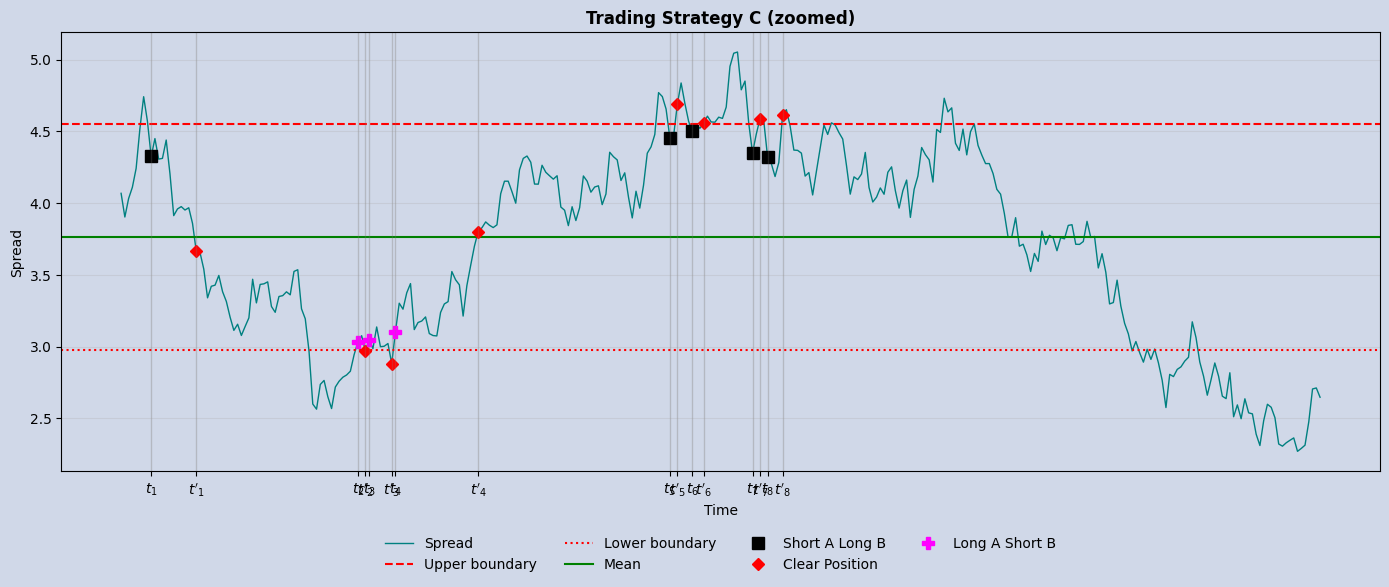

In [29]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread in window
ax.plot(S_win.index, S_win.values, color='teal', linewidth=1, label='Spread')

# Thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Markers (only trades fully inside the window)
shown_short = shown_long = shown_clear = False
tick_pos, tick_lab = [], []

K = min(8, len(trades_win))

for i, tr in enumerate(trades_win[:K], start=1):
    entry, exit_ = tr["entry"], tr["exit"]
    entry_val = S_win.loc[entry]
    exit_val  = S_win.loc[exit_]

    if tr["type"] == "short":
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(entry, entry_val, marker='P', linestyle='None', color='magenta',
                markersize=8, label='Long A Short B' if not shown_long else '')
        shown_long = True

    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=6, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_,  color='grey', alpha=0.25, linewidth=1)

    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# De-duplicate ticks (in case of coincidences)
seen = set()
tick_pos2, tick_lab2 = [], []
for p, l in zip(tick_pos, tick_lab):
    if p not in seen:
        tick_pos2.append(p); tick_lab2.append(l); seen.add(p)

ax.set_xticks(tick_pos2)
ax.set_xticklabels(tick_lab2)

ax.set_title("Trading Strategy C (zoomed)", fontsize=12, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Spread")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### heteroscedastic model

## Figure 3(b): Trading Strategy C in Heteroscedastic Model

Dans le modèle hétéroscédastique (Model 3 du papier), la fonction de volatilité $g(x)$ dépend de l'état:
$$g(x_t) = \sqrt{q_{base} + q_{het} \cdot x_t^2}$$

Les **boundaries U et L varient dans le temps** en fonction de cette volatilité conditionnelle:
$$U_t = \mu + k \cdot g(x_t), \quad L_t = \mu - k \cdot g(x_t)$$

**Note**: Les données réelles PEP-KO sont quasi-homoscédastiques ($q_{het} \approx 0$). Pour illustrer l'effet des boundaries time-varying, nous utilisons le **Model 3** du papier avec des paramètres simulés.

In [30]:

# Model 3 parameters from paper
q_base_m3 = 0.00089
q_het_m3 = 0.08

# Compute g(x_t) = sqrt(q_base + q_het * x_t^2) for each filtered state

g_t = np.sqrt(q_base_m3 + q_het_m3 * S**2)
g_t_series = pd.Series(g_t, index=S.index, name="g_t")

print("📊 Volatility g(x_t) = sqrt(q_base + q_het * x_t^2):")
print(f"  g_t mean: {g_t_series.mean():.6f}")
print(f"  g_t std:  {g_t_series.std():.6f}")
print(f"  g_t min:  {g_t_series.min():.6f}")
print(f"  g_t max:  {g_t_series.max():.6f}")
print("\n→ g(x) varies with the spread level (heteroscedasticity)")

📊 Volatility g(x_t) = sqrt(q_base + q_het * x_t^2):
  g_t mean: 1.064884
  g_t std:  0.222912
  g_t min:  0.569860
  g_t max:  1.648981

→ g(x) varies with the spread level (heteroscedasticity)


In [31]:
# Compute TIME-VARYING boundaries based on g(x_t)
# U_t = μ + k * g(x_t),  L_t = μ - k * g(x_t)
mu_het = S.mean()
k_het = 1.0  # Number of g(x) multiples (similar to σ rule)

# Scale g_t to match spread scale (paper uses different normalization)
# We scale so that average boundary width matches homoscedastic case
sigma_x = S.std(ddof=0)            # or ddof=1, just be consistent
g_bar   = g_t.mean()
U_t = mu + k_het * sigma_x * (g_t / g_bar)
L_t = mu - k_het * sigma_x * (g_t / g_bar)

C_het = mu_het  # Mean (constant)

print(f"Time-varying thresholds (k={k_het} × g(x) rule):")
print(f"  U_t range: [{U_t.min():.4f}, {U_t.max():.4f}]")
print(f"  L_t range: [{L_t.min():.4f}, {L_t.max():.4f}]")
print(f"  C (mean):  {C_het:.4f}")
print("\n→ Boundaries expand when spread is far from mean (high volatility)")
print("→ Boundaries contract when spread is near mean (low volatility)")

Time-varying thresholds (k=1.0 × g(x) rule):
  U_t range: [4.1851, 4.9836]
  L_t range: [2.5431, 3.3417]
  C (mean):  3.7634

→ Boundaries expand when spread is far from mean (high volatility)
→ Boundaries contract when spread is near mean (low volatility)


In [32]:
# Apply Strategy C with TIME-VARYING boundaries (from module)
signals_C_het = strategy_C_signals_timevarying(S, U_t, L_t, C_het)
trades_C_het = find_trades(signals_C_het)

print(f"Strategy C (Heteroscedastic Model 3): {len(trades_C_het)} completed trades")
print(f"  Short trades: {sum(1 for t in trades_C_het if t['type'] == 'short')}")
print(f"  Long trades:  {sum(1 for t in trades_C_het if t['type'] == 'long')}")

Strategy C (Heteroscedastic Model 3): 22 completed trades
  Short trades: 10
  Long trades:  12


In [33]:
t_start = 1
t_end   = 450
S_plot   = S.iloc[t_start:t_end]
U_plot   = U_t.iloc[t_start:t_end]
L_plot   = L_t.iloc[t_start:t_end]
trades_plot = [
    t for t in trades_C_het
    if (t_start <= S.index.get_loc(t['entry']) < t_end)
       and (t_start <= S.index.get_loc(t['exit'])  < t_end)
]
C_plot = C_het


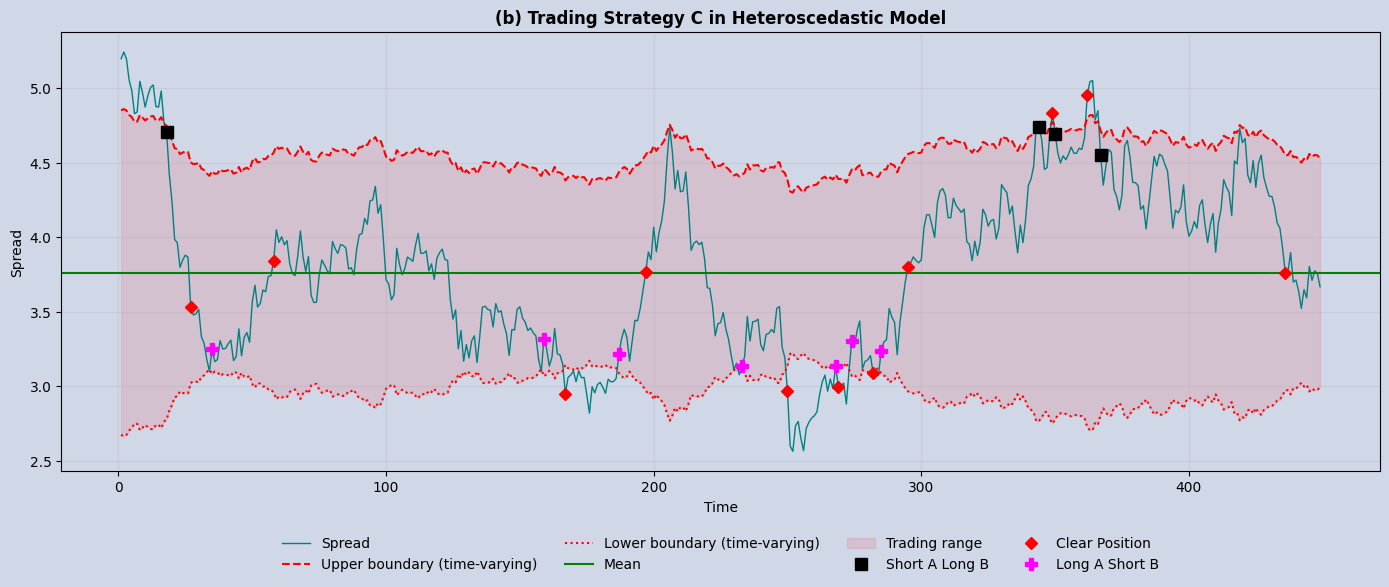

In [34]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread
ax.plot(S_plot.index, S_plot.values, 'teal', linewidth=1, label='Spread')

# Time-varying boundaries
ax.plot(U_plot.index, U_plot.values, 'r--', linewidth=1.5, label='Upper boundary (time-varying)')
ax.plot(L_plot.index, L_plot.values, 'r:',  linewidth=1.5, label='Lower boundary (time-varying)')
ax.axhline(y=C_plot, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Trading range
ax.fill_between(U_plot.index, L_plot.values, U_plot.values,
                alpha=0.1, color='red', label='Trading range')


shown_short = shown_long = shown_clear = False

for trade in trades_plot[:20]:
    entry_val = S.loc[trade['entry']]
    exit_val  = S.loc[trade['exit']]

    if trade['type'] == 'short':
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=8,
                label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=8,
                label='Long A Short B' if not shown_long else '')
        shown_long = True

    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=6,
            label='Clear Position' if not shown_clear else '')
    shown_clear = True


ax.set_title('(b) Trading Strategy C in Heteroscedastic Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()